In [18]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import importlib
import sys
sys.path.insert(1, '../')
import qtm.base, qtm.constant, qtm.nqubit, qtm.fubini_study, qtm.progress_bar
importlib.reload(qtm.base)
importlib.reload(qtm.constant)

<module 'qtm.constant' from '..\\qtm\\constant.py'>

### GHZ

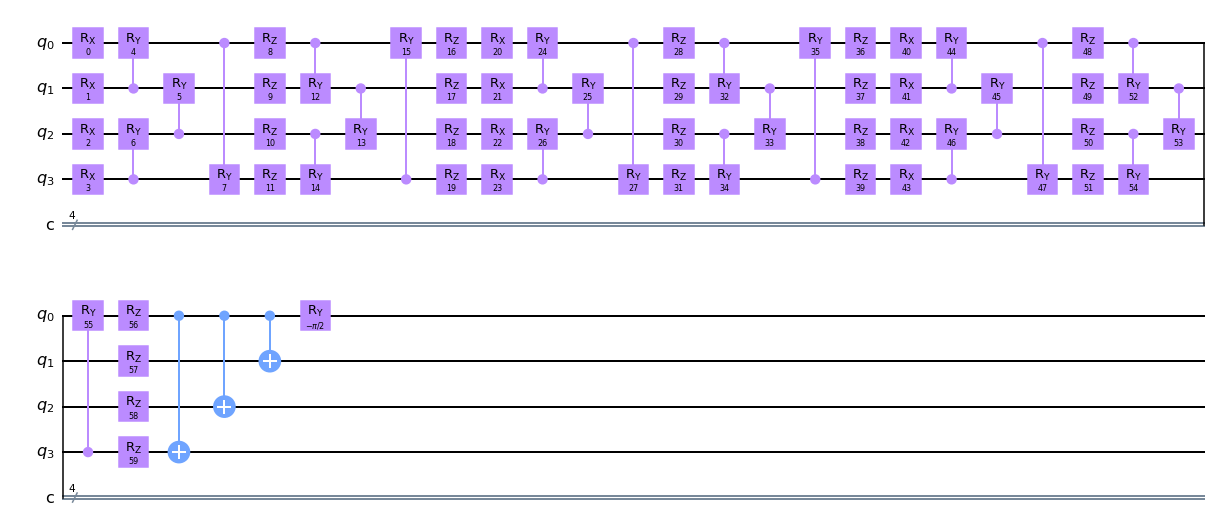

In [21]:
num_qubits = 3
num_layers = 2
thetas = np.ones(num_qubits*num_layers*5)
for i in range(0, len(thetas)):
    thetas[i] = i
theta = np.pi / 2
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
qc = qtm.nqubit.create_GHZchecker_linear(qc, thetas, num_layers, theta)
qc.draw('mpl')

In [11]:
num_qubits = 3
num_layers = 2
thetas = np.ones(num_qubits*num_layers*5)
theta = np.pi / 2
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
loss_values = []
thetass = []
G = qtm.fubini_study.qng(qc.copy(), thetas, qtm.nqubit.create_linear_state, num_layers)
print(G)

[['rx', 2], ['rx', 1], ['rx', 0]]
[['cry', 2]]
[['cry', 1]]
[['cry', 0]]
[['rz', 2], ['rz', 1], ['rz', 0]]
[['cry', 1]]
[['cry', 0]]
[['cry', 2]]
[['rz', 2], ['rz', 1], ['rz', 0]]
     ┌───────┐┌───────┐                  ┌───────┐                  ┌───────┐»
q_0: ┤ Rx(1) ├┤ Ry(1) ├─────────────■────┤ Rz(1) ├────■─────────────┤ Ry(1) ├»
     ├───────┤└───┬───┘┌───────┐    │    ├───────┤┌───┴───┐         └───┬───┘»
q_1: ┤ Rx(1) ├────■────┤ Ry(1) ├────┼────┤ Rz(1) ├┤ Ry(1) ├────■────────┼────»
     ├───────┤         └───┬───┘┌───┴───┐├───────┤└───────┘┌───┴───┐    │    »
q_2: ┤ Rx(1) ├─────────────■────┤ Ry(1) ├┤ Rz(1) ├─────────┤ Ry(1) ├────■────»
     └───────┘                  └───────┘└───────┘         └───────┘         »
c: 3/════════════════════════════════════════════════════════════════════════»
                                                                             »
«     ┌───────┐
«q_0: ┤ Rz(1) ├
«     ├───────┤
«q_1: ┤ Rz(1) ├
«     ├───────┤
«q_2: ┤ Rz(1) ├
«     └──────

In [19]:
num_qubits = 3
num_layers = 2
thetas = np.ones(num_qubits*num_layers*5)
theta = np.pi / 2
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
loss_values = []
thetass = []
bar = qtm.progress_bar.ProgressBar(max_value=100, disable=False)
for i in range(0, 2):
    bar.update(1)
    G = qtm.fubini_study.qng(qc.copy(), thetas, qtm.nqubit.create_linear_state, num_layers)
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_GHZchecker_linear, 
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers, theta = theta)
    thetas = np.real(thetas - qtm.constant.learning_rate*(np.linalg.pinv(G) @ grad_loss))   
    qc_copy = qtm.nqubit.create_GHZchecker_linear(qc.copy(), thetas, num_layers, theta)
    loss = qtm.base.loss_fubini_study(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)
    thetass.append(thetas)
bar.close()
np.savetxt("../../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/loss_values_qng.csv", loss_values, delimiter=",")
np.savetxt("../../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/thetass_qng.csv", thetass, delimiter=",")


Step:   0%|          | 0/100 [00:00<?, ?it/s]

[0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]


Step:   2%|▏         | 2/100 [00:33<27:40, 16.94s/it]

[0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]


Step:   2%|▏         | 2/100 [00:54<44:50, 27.46s/it]


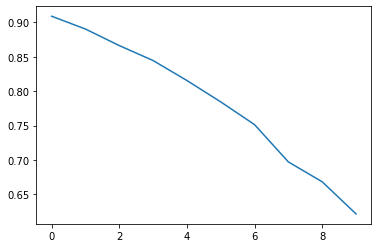

In [ ]:
plt.plot(loss_values)

In [ ]:
traces = []
fidelities = []
i = 0
for thetas in thetass:
    # Get |psi> = U_gen|000...>
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_linear_state(qc, thetas, num_layers)
    psi = qiskit.quantum_info.Statevector.from_instruction(qc)
    rho_psi = qiskit.quantum_info.DensityMatrix(psi)
    # Get |psi~> = U_target|000...>
    qc1 = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc1 = qtm.nqubit.create_ghz_state(qc1, theta)
    psi_hat = qiskit.quantum_info.Statevector.from_instruction(qc1)
    rho_psi_hat = qiskit.quantum_info.DensityMatrix(psi_hat)
    # Calculate the metrics
    trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
    traces.append(trace)
    fidelities.append(fidelity)
np.savetxt("../../experiments/linear_ansatz_ghz/" + str(num_qubits) +  "./traces_qng.csv", traces, delimiter=",")
np.savetxt("../../experiments/linear_ansatz_ghz/" + str(num_qubits) + "./fidelities_qng.csv", fidelities, delimiter=",")

# W

In [13]:
num_qubits = 3
num_layers = 2
thetas = np.ones(num_qubits*num_layers*5)
theta = np.pi / 2
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
loss_values = []
thetass = []
bar = qtm.progress_bar.ProgressBar(max_value=100, disable=False)
for i in range(0, 100):
    bar.update(1)
    G = qtm.fubini_study.calculate_linear_state(qc.copy(), thetas, num_layers)
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_Wchecker_linear, 
        thetas, r = 1/2, s = np.pi/2, type = 'control', num_layers = num_layers)
    thetas = np.real(thetas - qtm.constant.learning_rate*(np.linalg.pinv(G) @ grad_loss))   
    qc_copy = qtm.nqubit.create_Wchecker_linear(qc.copy(), thetas, num_layers)
    loss = qtm.base.loss_fubini_study(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)
    thetass.append(thetas)
bar.close()
np.savetxt("./loss_values_wqng.csv", loss_values, delimiter=",")
np.savetxt("./thetass_wqng.csv", thetass, delimiter=",")


Step:  58%|█████▊    | 58/100 [37:52<34:40, 49.54s/it]

In [ ]:
traces = []
fidelities = []
i = 0
for thetas in thetass:
    # Get |psi> = U_gen|000...>
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_linear_state(qc, thetas, num_layers)
    psi = qiskit.quantum_info.Statevector.from_instruction(qc)
    rho_psi = qiskit.quantum_info.DensityMatrix(psi)
    # Get |psi~> = U_target|000...>
    qc1 = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc1 = qtm.nqubit.create_w_state(qc1)
    psi_hat = qiskit.quantum_info.Statevector.from_instruction(qc1)
    rho_psi_hat = qiskit.quantum_info.DensityMatrix(psi_hat)
    # Calculate the metrics
    trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
    traces.append(trace)
    fidelities.append(fidelity)
np.savetxt("./traces_wqng.csv", traces, delimiter=",")
np.savetxt("./fidelities_wqng.csv", fidelities, delimiter=",")

### Others

In [17]:
import os, qiskit, qtm.constant, qtm.nqubit, pandas as pd, numpy as np

thetass = pd.read_csv("../../experiments/linear_ansatz_ghz/3/thetass_adam.csv", sep=",", header=None).to_numpy()
traces = []
fidelities = []
i = 0
num_layers = 2
num_qubits = 3
for thetas in thetass:
    # Get |psi> = U_gen|000...>
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_linear_state(qc, thetas, num_layers)
    psi, rho_psi = qtm.base.extract_state(qc)
    # Get |psi~> = U_target|000...>
    qc1 = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc1 = qtm.nqubit.create_w_state(qc1)
    psi_hat, rho_psi_hat = qtm.base.extract_state(qc1)
    # Calculate the metrics
    trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
    traces.append(trace)
    fidelities.append(fidelity)
np.savetxt("../../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/traces_adam.csv", traces, delimiter=",")
np.savetxt("../../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/fidelities_adam.csv", fidelities, delimiter=",")

### Compare number of layers

In [2]:
num_qubits = 7
num_layers = 4
thetas = np.ones((num_qubits*num_layers*5))
theta = np.pi / 2
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
loss_values = []
thetass = []
bar = qtm.progress_bar.ProgressBar(max_value=200, disable=False)
for i in range(0, 1):
    bar.update(1)
    G = qtm.fubini_study.qng(qc.copy(), thetas, qtm.nqubit.create_linear_state, num_layers)
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_GHZchecker_linear, 
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers, theta = theta)
    thetas = np.real(thetas - qtm.constant.learning_rate*(np.linalg.inv(G) @ grad_loss))   
    qc_copy = qtm.nqubit.create_GHZchecker_linear(qc.copy(), thetas, num_layers, theta)
    loss = qtm.base.loss_fubini_study(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)
    thetass.append(thetas)
bar.close()
np.savetxt("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/loss_values_qng" + str(num_layers) + ".csv", loss_values, delimiter=",")
np.savetxt("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/thetass_qng" + str(num_layers) + ".csv", thetass, delimiter=",")


Step: 100%|██████████| 200/200 [1:48:39<00:00, 32.60s/it]


In [18]:
thetass_tmp = pd.read_csv("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/thetass_qng" + str(num_layers) + ".csv", sep=",", header=None).to_numpy()
loss_values_tmp = pd.read_csv("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/loss_values_qng" + str(num_layers) + ".csv", sep=",", header=None).to_numpy()
loss_values = []
for loss in loss_values_tmp:
    loss_values.append(loss[0])
num_qubits = 7
num_layers = 4
thetass = []
for thetas in thetass_tmp:
    thetass.append(thetas[0])

thetas = thetass[-1]
theta = np.pi / 2
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
bar = qtm.progress_bar.ProgressBar(max_value=200, disable=False)
for i in range(0, 200):
    bar.update(1)
    G = qtm.fubini_study.qng(qc.copy(), thetas, qtm.nqubit.create_linear_state, num_layers)
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_GHZchecker_linear, 
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers, theta = theta)
    thetas = np.real(thetas - qtm.constant.learning_rate*(np.linalg.inv(G) @ grad_loss))   
    qc_copy = qtm.nqubit.create_GHZchecker_linear(qc.copy(), thetas, num_layers, theta)
    loss = qtm.base.loss_fubini_study(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)
    thetass.append(thetas)

Step:   0%|          | 1/200 [07:18<24:14:48, 438.64s/it]


TypeError: object of type 'numpy.float64' has no len()

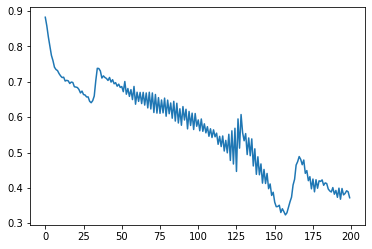

In [3]:
plt.plot(loss_values)

In [4]:
traces = []
fidelities = []
i = 0
for thetas in thetass:
    # Get |psi> = U_gen|000...>
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_linear_state(qc, thetas, num_layers)
    psi = qiskit.quantum_info.Statevector.from_instruction(qc)
    rho_psi = qiskit.quantum_info.DensityMatrix(psi)
    # Get |psi~> = U_target|000...>
    qc1 = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc1 = qtm.nqubit.create_ghz_state(qc1, theta)
    psi_hat = qiskit.quantum_info.Statevector.from_instruction(qc1)
    rho_psi_hat = qiskit.quantum_info.DensityMatrix(psi_hat)
    # Calculate the metrics
    trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
    traces.append(trace)
    fidelities.append(fidelity)
np.savetxt("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/traces_qng" + str(num_layers) + ".csv", traces, delimiter=",")
np.savetxt("../experiments/linear_ansatz_ghz/" + str(num_qubits) + "/fidelities_qng" + str(num_layers) + ".csv", fidelities, delimiter=",")

In [5]:
num_qubits = 7
num_layers = 5
thetas = np.ones((num_qubits*num_layers*5))
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
loss_values = []
thetass = []
bar = qtm.progress_bar.ProgressBar(max_value=200, disable=False)
for i in range(0, 200):
    bar.update(1)
    G = qtm.fubini_study.qng(qc.copy(), thetas, qtm.nqubit.create_linear_state, num_layers)
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_Wchecker_linear, 
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers)
    thetas = np.real(thetas - qtm.constant.learning_rate*(np.linalg.inv(G) @ grad_loss))   
    qc_copy = qtm.nqubit.create_Wchecker_linear(qc.copy(), thetas, num_layers)
    loss = qtm.base.loss_fubini_study(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)
    thetass.append(thetas)
bar.close()
np.savetxt("../experiments/linear_ansatz_w/" + str(num_qubits) + "/loss_values_qng" + str(num_layers) + ".csv", loss_values, delimiter=",")
np.savetxt("../experiments/linear_ansatz_w/" + str(num_qubits) + "/thetass_qng" + str(num_layers) + ".csv", thetass, delimiter=",")


Step: 100%|██████████| 200/200 [2:30:44<00:00, 45.22s/it]  


In [6]:
traces = []
fidelities = []
i = 0
for thetas in thetass:
    # Get |psi> = U_gen|000...>
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_linear_state(qc, thetas, num_layers)
    psi = qiskit.quantum_info.Statevector.from_instruction(qc)
    rho_psi = qiskit.quantum_info.DensityMatrix(psi)
    # Get |psi~> = U_target|000...>
    qc1 = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc1 = qtm.nqubit.create_w_state(qc1)
    psi_hat = qiskit.quantum_info.Statevector.from_instruction(qc1)
    rho_psi_hat = qiskit.quantum_info.DensityMatrix(psi_hat)
    # Calculate the metrics
    trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
    traces.append(trace)
    fidelities.append(fidelity)
np.savetxt("../experiments/linear_ansatz_w/" + str(num_qubits) + "/traces_qng" + str(num_layers) + ".csv", traces, delimiter=",")
np.savetxt("../experiments/linear_ansatz_w/" + str(num_qubits) + "/fidelities_qng" + str(num_layers) + ".csv", fidelities, delimiter=",")